In [1]:
from sklearn.datasets import fetch_openml
import pandas as pd
import numpy as np


dataset = fetch_openml(data_id=187 , as_frame=True)
df = dataset.frame
df.head(5)

,class,Alcohol,Malic_acid,Ash,Alcalinity_of_ash,Magnesium,Total_phenols,Flavanoids,Nonflavanoid_phenols,Proanthocyanins,Color_intensity,Hue,OD280%2FOD315_of_diluted_wines,Proline
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


In [2]:
df.info();

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 178 entries, 0 to 177
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   class                           178 non-null    category
 1   Alcohol                         178 non-null    float64 
 2   Malic_acid                      178 non-null    float64 
 3   Ash                             178 non-null    float64 
 4   Alcalinity_of_ash               178 non-null    float64 
 5   Magnesium                       178 non-null    int64   
 6   Total_phenols                   178 non-null    float64 
 7   Flavanoids                      178 non-null    float64 
 8   Nonflavanoid_phenols            178 non-null    float64 
 9   Proanthocyanins                 178 non-null    float64 
 10  Color_intensity                 178 non-null    float64 
 11  Hue                             178 non-null    float64 
 12  OD280%2FOD315_of_dilut

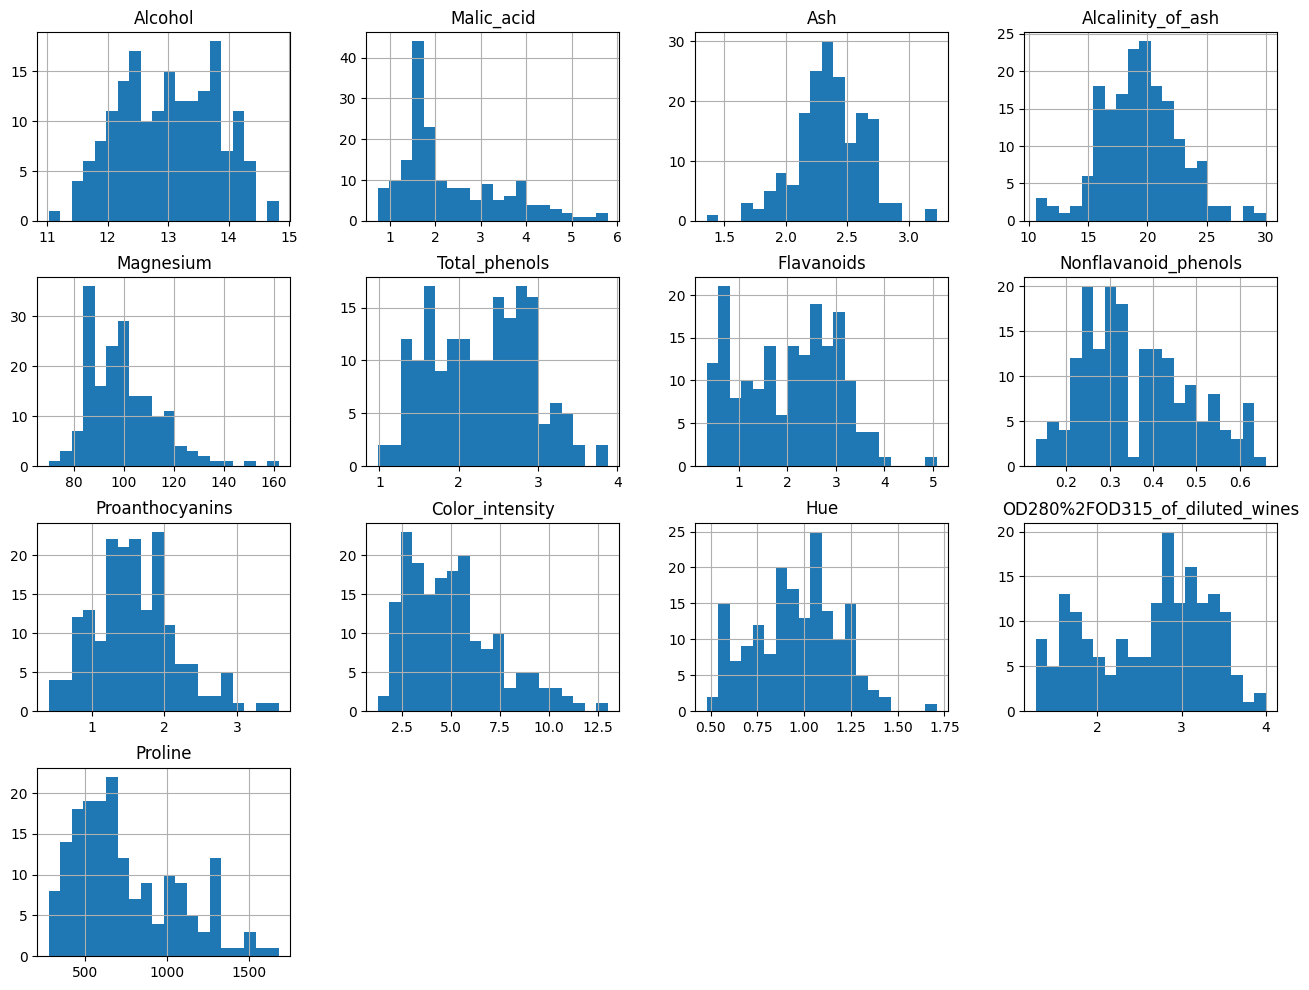

In [3]:
df.hist(bins = 20, figsize=(16, 12));

In [4]:
# حذف اوت لایر ها
features = df.drop(columns='class')

Q1 = features.quantile(0.25)
Q3 = features.quantile(0.75)
IQR = Q3 - Q1

outlier_mask = ~((features < (Q1 - 1.5 * IQR)) | (features > (Q3 + 1.5 * IQR))).any(axis=1)
df = df[outlier_mask]


Text(0.5, 1.0, 'Correlation Matrix')

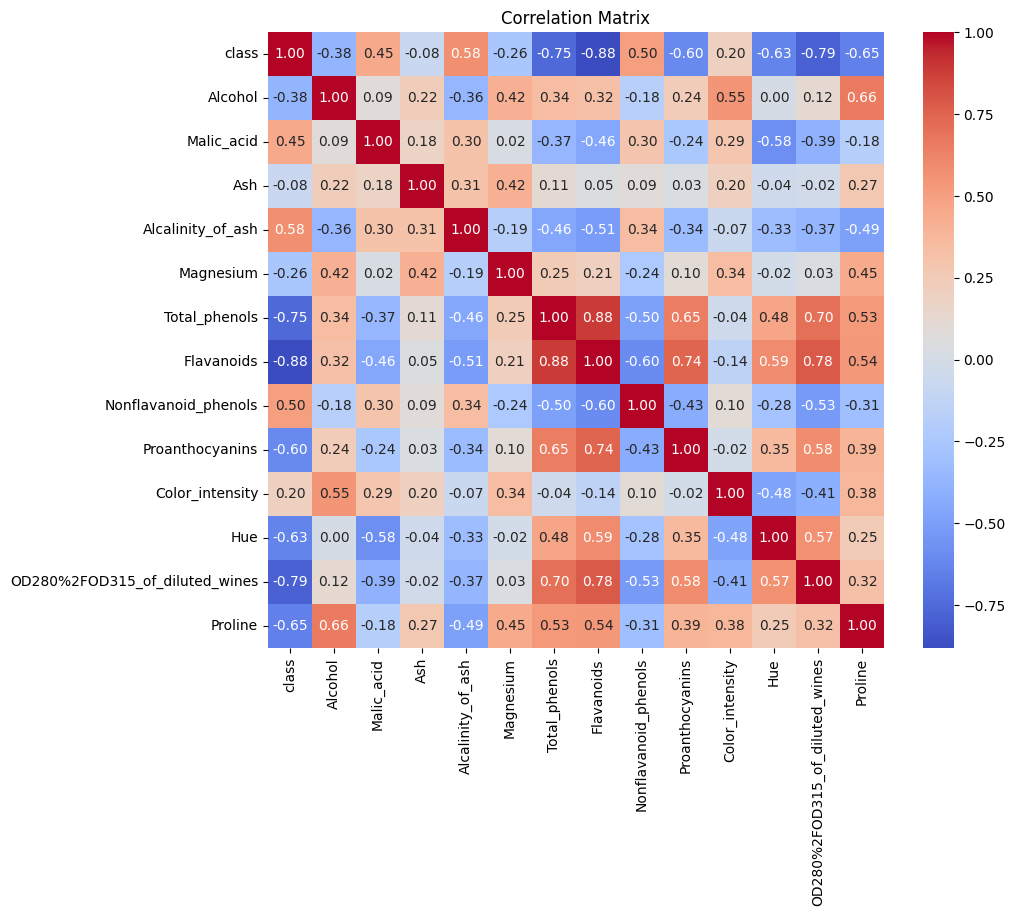

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# محاسبه ماتریس همبستگی
corr_matrix = df.corr()

# رسم heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', square=True)
plt.title("Correlation Matrix")

In [6]:
df['class'].value_counts()


,count
class,
2,61
1,58
3,42


In [7]:
x = df.drop(columns='class')
y = df['class']

In [8]:
from sklearn.model_selection import train_test_split

x_train , x_test , y_train , y_test = train_test_split(x , y , train_size=0.3 , random_state=42 , stratify = y)

In [40]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

pipe = Pipeline ([
    ('scaler',StandardScaler()),
    ('model', SVC(probability=True,random_state=42))
])

In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'model__C' : [0.1,1,10],
    'model__kernel' : ['sigmoid','poly','rbf','linear'],
    'model__gamma' : ['scale', 'auto']
}

grid = GridSearchCV (
    estimator= pipe ,
    param_grid= param_grid ,
    cv = 10 ,
    scoring = 'f1_macro',
    n_jobs= -1
)

grid.fit (x_train , y_train)

GridSearchCV(cv=10,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('model', SVC(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__C': [0.1, 1, 10],
                         'model__gamma': ['scale', 'auto'],
                         'model__kernel': ['sigmoid', 'poly', 'rbf', 'linear']},
             scoring='f1_macro')

In [14]:
Best_parameters=grid.best_params_
Best_parameters

{'model__C': 1, 'model__gamma': 'scale', 'model__kernel': 'sigmoid'}

In [17]:
y_pred = grid.predict(x_test)

In [18]:
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve
from sklearn.preprocessing import label_binarize

Text(0.5, 1.0, 'Confusion Matrix')

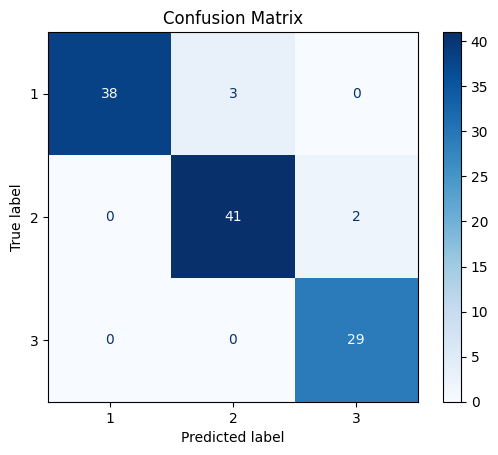

In [19]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=grid.classes_)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')

In [25]:
# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
y_test_bin = label_binarize(y_test, classes=np.unique(y))
y_pred_proba = grid.decision_function(x_test)
roc_auc = roc_auc_score(y_test_bin, y_pred_proba, average='macro', multi_class='ovr')
print(f"\nROC AUC Score: {roc_auc:.4f}")


Classification Report:
              precision    recall  f1-score   support

           1       1.00      0.93      0.96        41
           2       0.93      0.95      0.94        43
           3       0.94      1.00      0.97        29

    accuracy                           0.96       113
   macro avg       0.96      0.96      0.96       113
weighted avg       0.96      0.96      0.96       113


ROC AUC Score: 0.9967


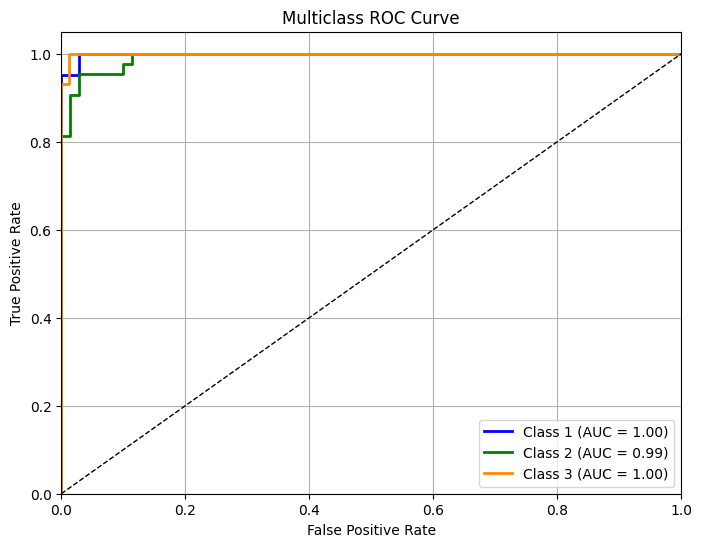

In [43]:
y_test_bin = label_binarize(y_test, classes=grid.classes_)
n_classes = y_test_bin.shape[1]

# احتمال‌ها به جای decision_function اگر نیاز بود:
y_score = grid.best_estimator_.decision_function(x_test)

# ROC per class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot
plt.figure(figsize=(8,6))
colors = ['blue', 'green', 'darkorange']
for i, color in zip(range(n_classes), colors):
    true_class = grid.classes_[i]
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label=f'Class {true_class} (AUC = {roc_auc[i]:.2f})')

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Multiclass ROC Curve')
plt.legend(loc="lower right")
plt.grid()
plt.show()


In [27]:
from sklearn.metrics import matthews_corrcoef

# محاسبه MCC
mcc = matthews_corrcoef(y_test, y_pred)

print("Matthews Correlation Coefficient (MCC):", round(mcc, 4))


Matthews Correlation Coefficient (MCC): 0.9337


In [28]:
from sklearn.metrics import hamming_loss

# محاسبه Hamming Loss
hamming = hamming_loss(y_test, y_pred)

print("Hamming Loss:", round(hamming, 4))


Hamming Loss: 0.0442


In [44]:
from sklearn.metrics import log_loss

# پیش‌بینی احتمال کلاس‌ها
y_score = grid.best_estimator_.decision_function(x_test)

# محاسبه log loss
logloss = log_loss(y_test, y_proba)

print("Log Loss:", round(logloss, 4))


Log Loss: 0.0


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:3001: UserWarning: The y_pred values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


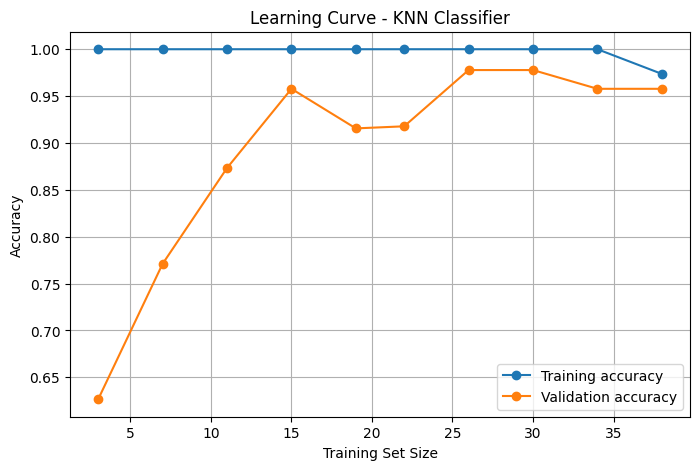

In [32]:
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import numpy as np

# محاسبه learning curve
train_sizes, train_scores, test_scores = learning_curve(
    estimator=grid.best_estimator_,
    X=x_train,
    y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),
    cv=5,
    scoring='accuracy',
    n_jobs=-1
)

# میانگین امتیازها
train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

# رسم نمودار
plt.figure(figsize=(8, 5))
plt.plot(train_sizes, train_mean, 'o-', label='Training accuracy')
plt.plot(train_sizes, test_mean, 'o-', label='Validation accuracy')
plt.xlabel('Training Set Size')
plt.ylabel('Accuracy')
plt.title('Learning Curve - KNN Classifier')
plt.legend()
plt.grid(True)
plt.show()


In [33]:
from sklearn.metrics import accuracy_score

# پیش‌بینی
y_train_pred = grid.predict(x_train)
y_test_pred = grid.predict(x_test)

# محاسبه دقت
train_acc = accuracy_score(y_train, y_train_pred)
test_acc = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_acc:.3f}")
print(f"Test Accuracy : {test_acc:.3f}")


Train Accuracy: 0.979
Test Accuracy : 0.956


In [37]:
from sklearn.model_selection import cross_val_score

# اعمال cross validation با بهترین مدل روی داده‌ی آموزش
cv_scores = cross_val_score(grid.best_estimator_, x_train, y_train, cv=10, scoring='f1_macro')

# میانگین و انحراف معیار امتیازها
print("Cross Validation Scores:", cv_scores)
print("Mean CV Score:", cv_scores.mean())
print("Standard Deviation:", cv_scores.std())

# امتیاز واقعی روی داده تست
from sklearn.metrics import f1_score
test_score = f1_score(y_test, grid.predict(x_test), average='macro')
print("Test Set Score:", test_score)


Cross Validation Scores: [0.82222222 1.         1.         1.         1.         1.
 1.         1.         1.         0.6       ]
Mean CV Score: 0.9422222222222223
Standard Deviation: 0.12578641509408806
Test Set Score: 0.9570735729181822
